In [1]:
%matplotlib inline
import requests
import jsm
from bs4 import BeautifulSoup
import sqlite3
import pandas as pd

In [2]:
q = jsm.Quotes()
b = q.get_brand()
ccodes = []
d = {}
for key in b:
    for i in b[key]:
        ccodes.append(i.ccode)
        d[i.ccode] = i.name # to convert compnay code to company name

/home/nwata/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/nwata/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [3]:
def get_profit(ccode):
    r = requests.get('https://profile.yahoo.co.jp/consolidate/{}'.format(ccode))
    bs = BeautifulSoup(r.text, 'lxml')
    text = bs.findAll('td')[39].text
    num = ''.join(s for s in text if s.isdigit())
    return int(num) if num else -1

def get_num_employees(ccode):
    r = requests.get('https://profile.yahoo.co.jp/fundamental/{}'.format(ccode))
    bs = BeautifulSoup(r.text, 'lxml')
    text = bs.findAll('td', attrs = {"width": "25%"})[-1].text
    num = ''.join(s for s in text if s.isdigit())
    return int(num) if num else -1

In [4]:
data = []
for ccode in ccodes:
    pft = get_profit(ccode)
    num = get_num_employees(ccode)
    per = round(pft / num, 2) if pft > 0 and num > 0 else -1
    datum = (ccode, pft, num, per)
    data.append(datum)

print('got net income and employees from {} companies out of {}'.format(len([i for i in data if i[3] > 0]), len(ccodes)))

got net income and employees from 3075 companies out of 3667


In [18]:
conn = sqlite3.connect('income_per_person.db')
c = conn.cursor()
c.execute('CREATE TABLE ccodes(ccode TEXT)')
c.executemany('INSERT INTO ccodes VALUES (?)', [(i,) for i in ccodes])
c.execute('CREATE TABLE names(ccode TEXT, name TEXT)')
c.executemany('INSERT INTO names VALUES (?, ?)', [(i, d[i]) for i in ccodes])
c.execute('CREATE TABLE companies(ccode TEXT, net_income INTEGER, employee INTEGER, per_person REAL)')
c.executemany('INSERT INTO companies VALUES (?, ?, ?, ?)', data)
conn.commit()

In [26]:
df_com = pd.io.sql.read_sql_query('SELECT ccode, net_income, employee, per_person FROM companies WHERE per_person > 0 ORDER BY per_person DESC', conn)
df_name = pd.io.sql.read_sql_query('SELECT ccode, name FROM names', conn)
df = df_com.join(df_name.set_index('ccode'), on='ccode')
df

,ccode,net_income,employee,per_person,name
0,8925,3094,19,162.84,(株)アルデプロ
1,8918,864,7,123.43,(株)ランド
2,3252,6437,69,93.29,日本商業開発(株)
3,2121,59867,662,90.43,(株)ミクシィ
4,4596,3952,44,89.82,窪田製薬ホールディングス(株)
5,4563,4776,55,86.84,アンジェス(株)
6,8818,3272,43,76.09,京阪神ビルディング(株)
7,8595,11073,152,72.85,(株)ジャフコ
8,1606,23053,339,68.00,日本海洋掘削(株)
9,4565,9797,145,67.57,そーせいグループ(株)


In [27]:
df.describe()

,net_income,employee,per_person
count,3.075000e+03,3075.000000,3075.000000
mean,1.252147e+04,5186.419187,3.305291
std,6.266829e+04,18747.043983,7.308593
min,2.000000e+00,5.000000,0.010000
25%,4.495000e+02,353.000000,0.720000
50%,1.422000e+03,917.000000,1.640000
75%,5.301500e+03,3021.500000,3.240000
max,1.831109e+06,364445.000000,162.840000


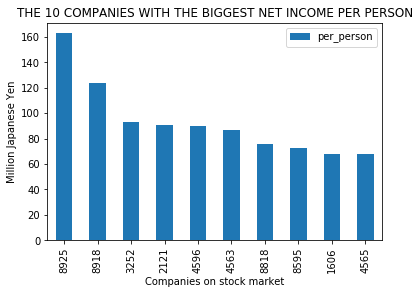

In [28]:
ax = df[:10].plot.bar(x='ccode', y='per_person')
ax.set_title('THE 10 COMPANIES WITH THE BIGGEST NET INCOME PER PERSON')
ax.set_xlabel('Companies on stock market')
ax.set_ylabel('Million Japanese Yen')

In [6]:
conn.close()